## Trabajo Fin de Grado
### Gestor de Quirófanos
### Implementación de Algoritmo Genético para asignación de quirófanos

#### Autor: Jesús García Armario

In [1]:
# Imports necesarios
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
import sys
sys.path.append('../')
from Heuristicas.Utils import Quirofano, ActoQuirurgico
import random
import math
import matplotlib.pyplot as plt

In [2]:
# Importamos el listado preprocesado de una especialidad para las pruebas
filename = '..\\..\\Datos\\Listados_Preprocesados\\ListadoInterv_Preprocesado_MAXILOFACIAL.xlsx'
df = pd.read_excel(filename)
# Seleccionamos una muestra aleatoria de 100 pacientes
df = df.sample(n=100, random_state=1)
# Nos quedamos sólo con el NHC, Ponderación y duración
df = df[['NHC', 'PONDERACIÓN', 'DURACIÓN']]
# Creamos un set de actos quirúrgicos
actos_pendientes = list()
i = 0
for elemento in df.itertuples():
    actos_pendientes.append(ActoQuirurgico(i, elemento[3], elemento[1], elemento[2]))
    i += 1

In [3]:
# Definimos un cromosoma como una lista de tamaño N
# donde N es el número de slots temporales disponibles
# El ID de la operación ocupará la posición del slot temporal o 0 si no se ha asignado
# El cromosoma se codifica como una lista de enteros
# Con separadores representados por caracteres especiales, siendo 'A' el separador de quirófanos
# y 'B' el separador de días
def cromosomaAleatorio(tiempos, quirofanos, dias, actos_pendientes, ventana):
    actos_pendientes = actos_pendientes.copy()
    cromosoma = []
    for i in range(dias):
        for j in range(quirofanos):
            tDisponibles = tiempos
            while tDisponibles > 0:
                # Seleccionamos un elemento al azar de actos_pendientes
                acto = random.choice(actos_pendientes)
                T = math.ceil(acto.getDuracion()/ventana)
                # Lo añadimos al cromosoma T veces
                for l in range(T):
                    cromosoma.append(acto.getId())
                # Añadimos un separador de intervenciones
                cromosoma.append(0)
                # Avanzamos el puntero de tiempos
                actos_pendientes.remove(acto)
                tDisponibles -= (T + 1)
            cromosoma.append('A')
        cromosoma.append('B')
    return cromosoma

In [9]:
print(cromosomaAleatorio(10, 2, 2, actos_pendientes, 30))

[68, 0, 36, 36, 36, 36, 36, 36, 36, 0, 'A', 46, 0, 49, 49, 49, 49, 49, 0, 51, 0, 'A', 'B', 37, 0, 22, 0, 45, 0, 91, 91, 91, 91, 91, 91, 0, 'A', 2, 0, 77, 0, 23, 23, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 'A', 'B']


In [4]:
# Definimos al individuo
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
toolbox.register("cromosoma", cromosomaAleatorio, 16, 3, 5, actos_pendientes, 30)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.cromosoma)
toolbox.register("poblacion", tools.initRepeat, list, toolbox.individual)

In [5]:
# Definimos la función de fitness
def evaluar(individual):
    # Calculamos el fitness como la suma de las ponderaciones de los actos quirúrgicos
    # Dividida entre los slots temporales vacíos
    # Si el individuo no es válido, su fitness será 0
    fitness = 0
    # Calculamos el fitness
    for i in range(len(individual)):
        if individual[i] != 0 and individual[i] != 'A' and individual[i] != 'B':
            fitness += actos_pendientes[individual[i]].getPrioridad()
    # Dividimos entre los slots temporales vacíos
    fitness = fitness / individual.count(0)
    return fitness,

In [6]:
def cruce(ind1, ind2):
    # Obtenemos las posiciónes de los separadores A y B en ambos padres
    posA1 = ind1.index('A')
    posA2 = ind2.index('A')
    posB1 = ind1.index('B')
    posB2 = ind2.index('B')
   # El hijo 1 tendrá los separadores A y B del padre 1
    hijo1 = ind1[:posA1] + ind2[posA2:posB2] + ind1[posB1:]
    # El hijo 2 tendrá los separadores A y B del padre 2
    hijo2 = ind2[:posA2] + ind1[posA1:posB1] + ind2[posB2:]
    return hijo1, hijo2
def mutacion(individual):
    # Intercambia dos genes de posición
    pos1 = random.randint(0, len(individual)-1)
    pos2 = random.randint(0, len(individual)-1)
    individual[pos1], individual[pos2] = individual[pos2], individual[pos1]
    return individual

In [7]:
toolbox.register("evaluate", evaluar)
toolbox.register("mate", cruce)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

Mejor individuo:  [20, 11, 98, 'A', 7, 0, 73, 47, 20, 0, 52, 'A', 58, 97, 0, 70, 98, 20, 87, 31, 55, 20, 0, 20, 98, 20, 98, 85, 34, 20, 20, 94, 20, 20, 0, 20, 0, 20, 0, 20, 20, 0, 97, 78, 20, 32, 20, 10, 98, 12, 73, 97, 'A', 54, 44, 78, 11, 'A', 98, 34, 12, 20, 20, 20, 7, 20, 98, 20, 83, 20, 20, 0, 20, 'A', 20, 20, 41, 0, 'A', 70, 98, 88, 98, 0, 71, 20, 20, 0, 71, 98, 91, 0, 78, 20, 78, 98, 34, 78, 78, 91, 20, 0, 3, 91, 32, 11, 78, 67, 91, 0, 34, 20, 3, 20, 0, 34, 34, 71, 98, 0, 'B', 55, 76, 98, 87, 0, 20, 87, 20, 'A', 72, 98, 3, 72, 11, 20, 0, 50, 94, 'A', 20, 45, 3, 54, 20, 49, 91, 3, 0, 3, 52, 98, 78, 87, 0, 71, 36, 61, 20, 0, 0, 'A', 69, 98, 98, 20, 98, 98, 88, 35, 98, 20, 0, 98, 98, 94, 20, 54, 20, 10, 69, 98, 14, 98, 71, 98, 94, 98, 6, 52, 98, 6, 98, 'A', 0, 0, 20, 98, 7, 98, 65, 0, 5, 3, 98, 49, 54, 98, 78, 32, 36, 3, 29, 94, 71, 0, 54, 0, 52, 3, 95, 98, 20, 0, 71, 32, 0, 55, 94, 98, 31, 71, 20, 98, 49, 71, 49, 98, 98, 98, 47, 20, 83, 9, 71, 71, 20, 6, 32, 'A', 65, 0, 68, 31, 3,

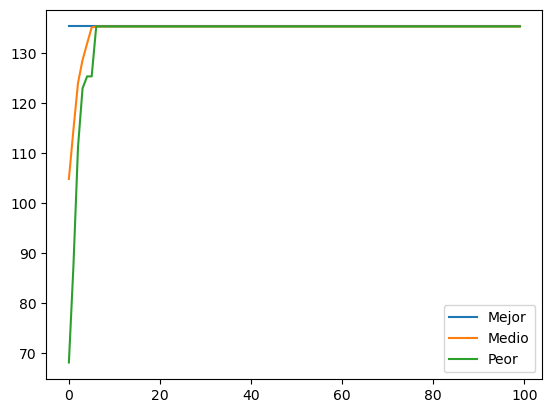

In [8]:
# Definimos los parámetros del algoritmo
# Tamaño de la población
tPoblacion = 100
# Probabilidad de cruce
pCruce = 0.8
# Probabilidad de mutación
pMutacion = 0.2
# Número de generaciones
nGeneraciones = 100
# Creamos la población inicial
poblacion = toolbox.poblacion(n=tPoblacion)
# Evaluamos la población inicial
fitnesses = list(map(toolbox.evaluate, poblacion))
for ind, fit in zip(poblacion, fitnesses):
    ind.fitness.values = fit
# Guardamos el mejor individuo
mejor = tools.selBest(poblacion, 1)[0]
# Guardamos el mejor fitness
mejorFitness = mejor.fitness.values[0]
# Guardamos el fitness medio
fitnessMedio = 0
# Guardamos el fitness del peor individuo
peorFitness = 0
# Guardamos el fitness del mejor individuo de cada generación
mejoresFitness = []
# Guardamos el fitness medio de cada generación
fitnessesMedios = []
# Guardamos el fitness del peor individuo de cada generación
peoresFitness = []

# Ejecutamos el algoritmo
for i in range(nGeneraciones):
    # Seleccionamos la siguiente generación
    offspring = toolbox.select(poblacion, len(poblacion))
    # Clonamos los individuos seleccionados
    offspring = list(map(toolbox.clone, offspring))
    # Aplicamos el cruce
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < pCruce:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    # Aplicamos la mutación
    for mutant in offspring:
        if random.random() < pMutacion:
            toolbox.mutate(mutant)
            del mutant.fitness.values
    # Evaluamos los individuos con fitness inválido
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    # Reemplazamos la población por la nueva generación
    poblacion[:] = offspring
    # Guardamos el mejor individuo
    mejor = tools.selBest(poblacion, 1)[0]
    # Guardamos el mejor fitness
    mejorFitness = max(mejorFitness, mejor.fitness.values[0])
    # Guardamos el fitness medio
    fitnessMedio = sum([ind.fitness.values[0] for ind in poblacion])/len(poblacion)
    # Guardamos el fitness del peor individuo
    peorFitness = min([ind.fitness.values[0] for ind in poblacion])
    # Guardamos el fitness del mejor individuo de cada generación
    mejoresFitness.append(mejorFitness)
    # Guardamos el fitness medio de cada generación
    fitnessesMedios.append(fitnessMedio)
    # Guardamos el fitness del peor individuo de cada generación
    peoresFitness.append(peorFitness)

# Mostramos los resultados
print("Mejor individuo: ", mejor)
print("Mejor fitness: ", mejorFitness)
print("Fitness medio: ", fitnessMedio)
print("Peor fitness: ", peorFitness)
# Mostramos la gráfica
plt.plot(mejoresFitness, label="Mejor")
plt.plot(fitnessesMedios, label="Medio")
plt.plot(peoresFitness, label="Peor")
plt.legend()
plt.show()